In [27]:
# _= !pip install jcopml

In [28]:
# _= !pip install sklearn-crfsuite

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
#import library

import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron
from jcopml.plot import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import joblib

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

In [32]:
from functools import wraps
from sklearn_crfsuite.utils import flatten


def _flattens_y(func):
  @wraps(func)
  def wrapper(y_true, y_pred, *args, **kwargs):
      y_true_flat = flatten(y_true)
      y_pred_flat = flatten(y_pred)
      return func(y_true_flat, y_pred_flat, *args, **kwargs)
  return wrapper

@_flattens_y
def flat_classification_report(y_true, y_pred, labels=None, **kwargs):
  """
  Return classification report for sequence items.
  """
  from sklearn import metrics
  return metrics.classification_report(y_true, y_pred, labels=labels, **kwargs)

@_flattens_y
def flat_multilabel_confusion_matrix(y_true, y_pred, labels=None, **kwargs):
  """
  Return classification report for sequence items.
  """
  from sklearn import metrics
  return metrics.multilabel_confusion_matrix(y_true, y_pred, labels=labels, **kwargs)

def plot_cm(y_test, y_pred, classes=None):
  mul_c = multilabel_confusion_matrix(y_test, y_pred, labels=classes)
  f, axes = plt.subplots(5, 5, figsize=(40, 20))
  axes = axes.ravel()
  for i in range(len(classes)):
      disp = ConfusionMatrixDisplay(mul_c[i].astype(int), )
      disp.plot(ax=axes[i], values_format='')
      disp.ax_.set_title(f'class {classes[i]}')
      # disp.ticklabel_format(useOffset=False)
      if i<20:
          disp.ax_.set_xlabel('')
      if i%5!=0:
          disp.ax_.set_ylabel('')
      disp.im_.colorbar.remove()

  plt.subplots_adjust(wspace=0.10, hspace=0.1)
  # f.colorbar(disp.im_, ax=axes)
  plt.show()

def plot_cm_crf(y_test, y_pred, classes=None):

  mul_c = flat_multilabel_confusion_matrix(y_test, y_pred, labels=classes)
  f, axes = plt.subplots(5, 5, figsize=(30, 15))
  axes = axes.ravel()
  for i in range(len(classes)):
      disp = ConfusionMatrixDisplay(mul_c[i].astype(int), )
      disp.plot(ax=axes[i], values_format='')
      disp.ax_.set_title(f'class {classes[i]}')
      # disp.ticklabel_format(useOffset=False)
      if i<20:
          disp.ax_.set_xlabel('')
      if i%5!=0:
          disp.ax_.set_ylabel('')
      disp.im_.colorbar.remove()

  plt.subplots_adjust(wspace=0.10, hspace=0.1)
  # f.colorbar(disp.im_, ax=axes)
  plt.show()


In [33]:
# path = '/content/drive/MyDrive/Project/NLP/' #drive
path = '../'

In [34]:
data = pd.read_csv(os.path.join(path, 'datasets','LEGALNER-POS-PREV-NEXT-200.csv'))

# Preproses

## fill missing value

In [35]:
df = data.fillna(method='ffill')

In [36]:
df

,doc,sentence,word,pos,prev,next,tag
0,doc: 13a5421c5a5de3dc125a2fd01278a5bb,sentence: 0000001,PUTUSAN,PROPN,.,.,O
1,doc: 13a5421c5a5de3dc125a2fd01278a5bb,sentence: 0000001,.,PUNCT,PUTUSAN,NOMOR,O
2,doc: 13a5421c5a5de3dc125a2fd01278a5bb,sentence: 0000001,NOMOR,PROPN,.,:,O
3,doc: 13a5421c5a5de3dc125a2fd01278a5bb,sentence: 0000001,:,PUNCT,NOMOR,1974,O
4,doc: 13a5421c5a5de3dc125a2fd01278a5bb,sentence: 0000001,1974,NUM,:,/,B_VERN
...,...,...,...,...,...,...,...
1048570,doc: 435b8e7537ce615374b4bf7d17e88e1b,sentence: 0039957,Bahwa,SCONJ,-,mekanisme,O
1048571,doc: 435b8e7537ce615374b4bf7d17e88e1b,sentence: 0039957,mekanisme,NOUN,Bahwa,perpanjangan,O
1048572,doc: 435b8e7537ce615374b4bf7d17e88e1b,sentence: 0039957,perpanjangan,NOUN,mekanisme,dan,O
1048573,doc: 435b8e7537ce615374b4bf7d17e88e1b,sentence: 0039957,dan,CCONJ,perpanjangan,penambahan,O


## check unique data

In [37]:
df.doc.nunique(), df.sentence.nunique(), df.word.nunique(), df.tag.nunique()

(107, 24515, 25912, 25)

## change unique doc to list

In [38]:
doc = df.doc.unique().tolist()
len(doc)

107

## finding last document as training data, training data = 75, testing data = 32

In [39]:
docLock = doc[74]
docLock

'doc: 75dcf2fd4083e7272c08e93296377e27'

## change all doc to list

In [40]:
a = df.index[df['doc'] == docLock].tolist()
len(a)

25731

## find last index for slicing



In [41]:
len_a = a[len(a)-1]
len_a

530116

In [42]:
df.shape

(1048575, 7)

## drop unused column and call dictionary vectorized function

In [43]:
X = df.drop(['doc','tag', 'pos', 'prev', 'next'], axis=1)
v = DictVectorizer()

## change data to dictionary

In [44]:
d = X.to_dict('Record')

## change to vector

In [45]:
b = v.fit_transform(d)
y = df.tag.values

## slice data, 140 document for training dan 60 document for test

In [46]:
X_train = b[:len_a+1]
y_train = y[:len_a+1]
X_test = b[len_a+1:]
y_test = y[len_a+1:]

In [47]:
X_train.shape, y_train.shape

((530117, 50427), (530117,))

## change label to list

In [48]:
classes = np.unique(y)
classes = classes.tolist()

# Model (proses without pos)

## train model MultinomialNB 

In [49]:
# from sklearn.model_selection import GridSearchCV
# parameters = {  
# 'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
# }  
# grid_search= GridSearchCV(MultinomialNB(), parameters)
# grid_search.fit(X_train,y_train)

In [50]:
# grid_search.best_params_

In [51]:
nb = MultinomialNB(alpha=1)
nb_start = time.time()
nb.partial_fit(X_train, y_train, classes)
nb_end = time.time()

### time model

In [52]:
print(f'{(nb_end - nb_start):.2f} Detik.')

0.58 Detik.


In [53]:
y_pred_nb = nb.predict(X_test)

### evaluasi

In [54]:
print(classification_report(y_pred=y_pred_nb, y_true=y_test, labels = classes))

              precision    recall  f1-score   support

      B_ADVO       0.00      0.00      0.00        49
      B_ARTV       0.75      0.61      0.68       669
      B_CRIA       0.00      0.00      0.00        31
      B_DEFN       0.41      0.22      0.29      5872
      B_JUDG       0.00      0.00      0.00        81
      B_JUDP       0.00      0.00      0.00        32
      B_PENA       0.00      0.00      0.00        30
      B_PROS       0.00      0.00      0.00        31
      B_PUNI       0.00      0.00      0.00        56
      B_REGI       0.00      0.00      0.00        36
      B_TIMV       0.00      0.00      0.00        32
      B_VERN       0.00      0.00      0.00       352
      I_ADVO       0.00      0.00      0.00       304
      I_ARTV       0.29      0.62      0.39      5969
      I_CRIA       0.00      0.00      0.00       229
      I_DEFN       0.07      0.70      0.13      9691
      I_JUDG       0.15      0.03      0.04       615
      I_JUDP       0.00    

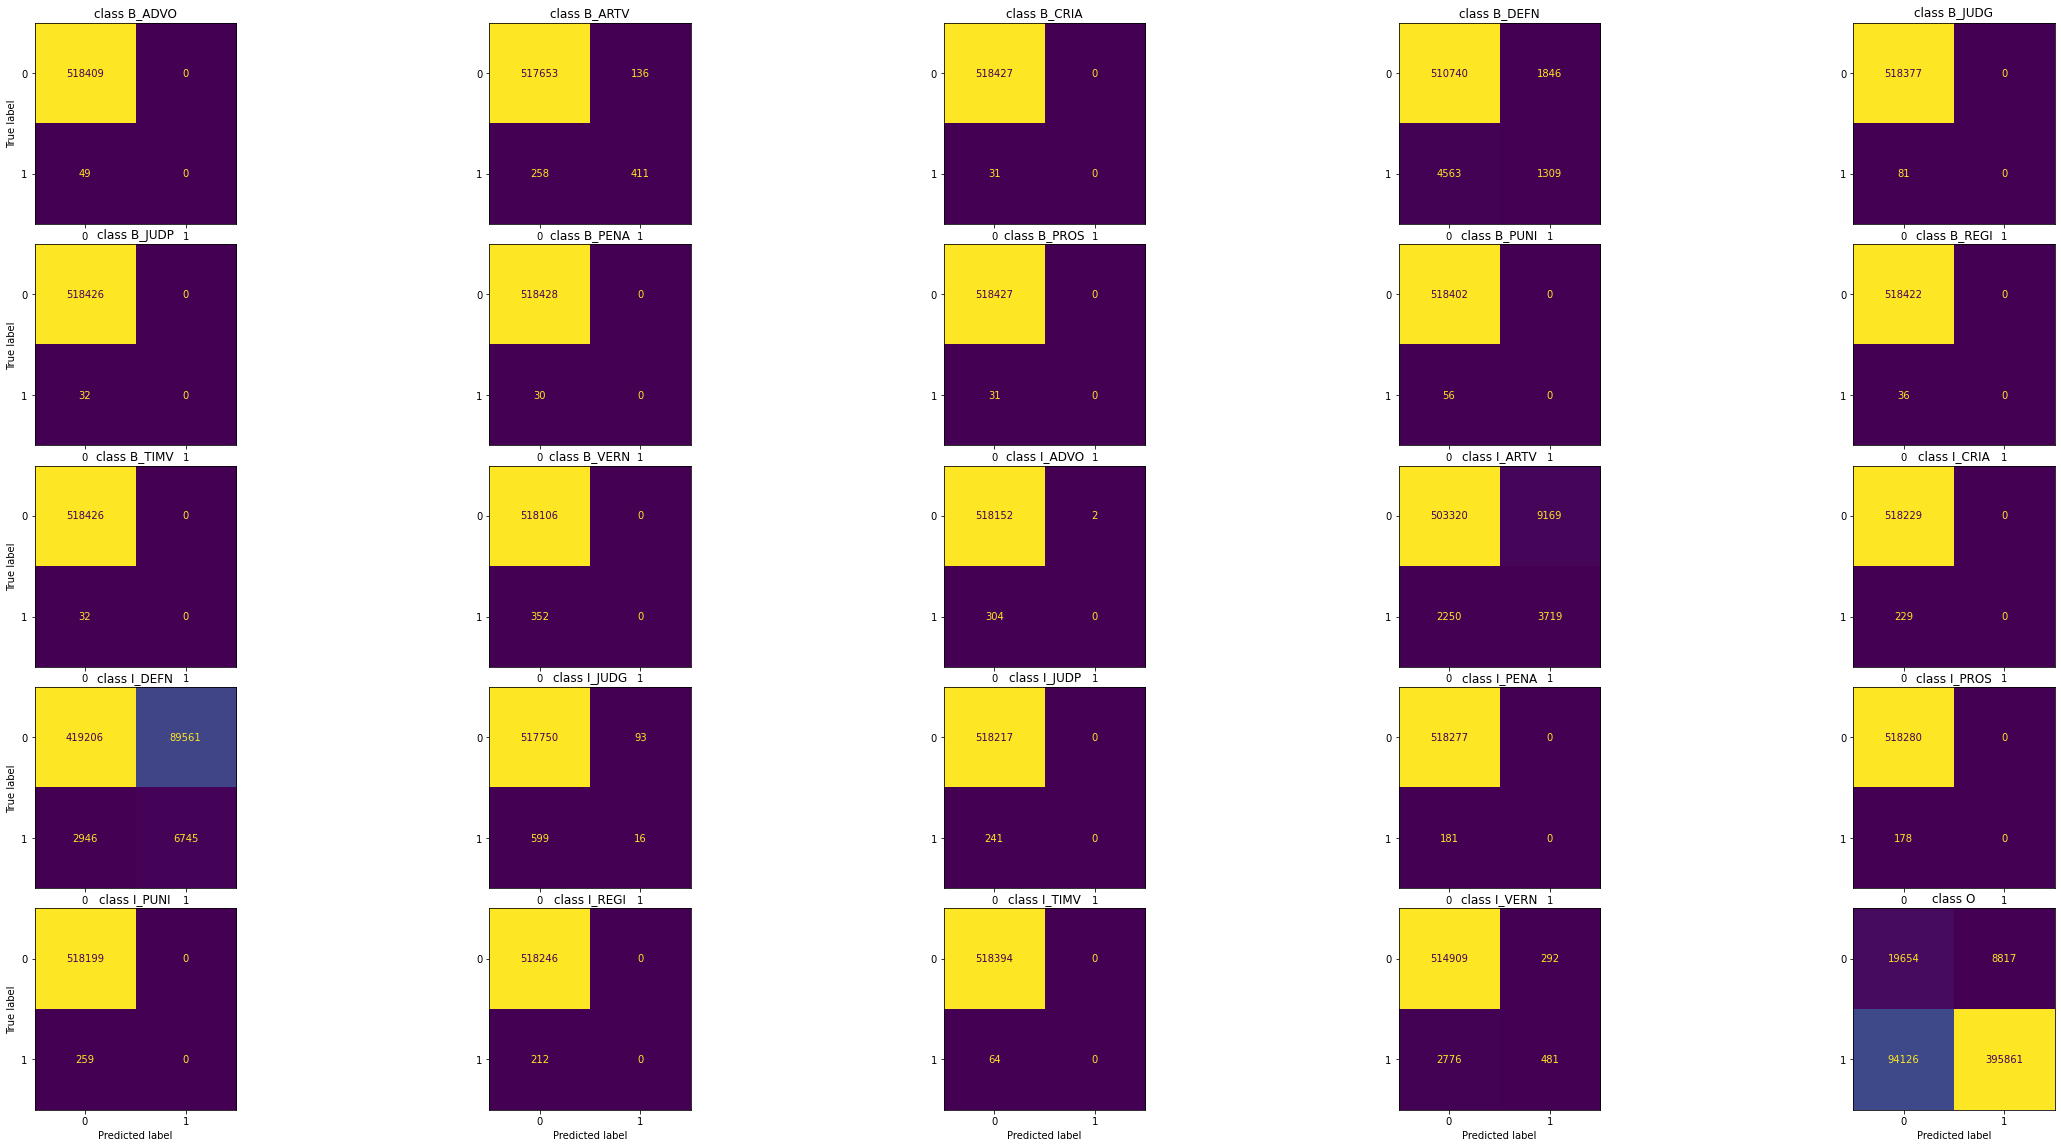

In [55]:
plot_cm(y_test, y_pred_nb, classes)

## train model Linear classifiers

In [56]:
sgd = SGDClassifier(max_iter=50, tol=1e-3)
sgd_start = time.time()
sgd.fit(X_train, y_train)
sgd_end = time.time()

### save model

In [57]:
# filename = os.path.join(path, 'model', 'model-sgd-26.pkl')
# joblib.dump(sgd, filename)

In [58]:
y_pred = sgd.predict(X_test)

### time model

In [59]:
print(f'{(sgd_end - sgd_start):.2f} Detik.')

10.52 Detik.


### evaluasi

In [60]:
print(classification_report(y_pred=sgd.predict(X_test), y_true=y_test, labels = classes))

              precision    recall  f1-score   support

      B_ADVO       0.00      0.00      0.00        49
      B_ARTV       0.75      0.61      0.68       669
      B_CRIA       0.00      0.00      0.00        31
      B_DEFN       0.71      0.01      0.02      5872
      B_JUDG       0.00      0.00      0.00        81
      B_JUDP       0.00      0.00      0.00        32
      B_PENA       0.00      0.00      0.00        30
      B_PROS       0.00      0.00      0.00        31
      B_PUNI       0.00      0.00      0.00        56
      B_REGI       0.00      0.00      0.00        36
      B_TIMV       0.00      0.00      0.00        32
      B_VERN       0.00      0.00      0.00       352
      I_ADVO       0.00      0.00      0.00       304
      I_ARTV       0.53      0.37      0.44      5969
      I_CRIA       0.00      0.00      0.00       229
      I_DEFN       0.53      0.08      0.14      9691
      I_JUDG       0.00      0.00      0.00       615
      I_JUDP       0.00    

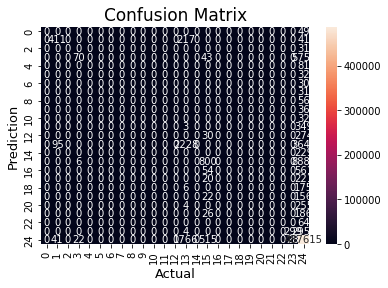

In [61]:
cm = confusion_matrix(y_test,y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

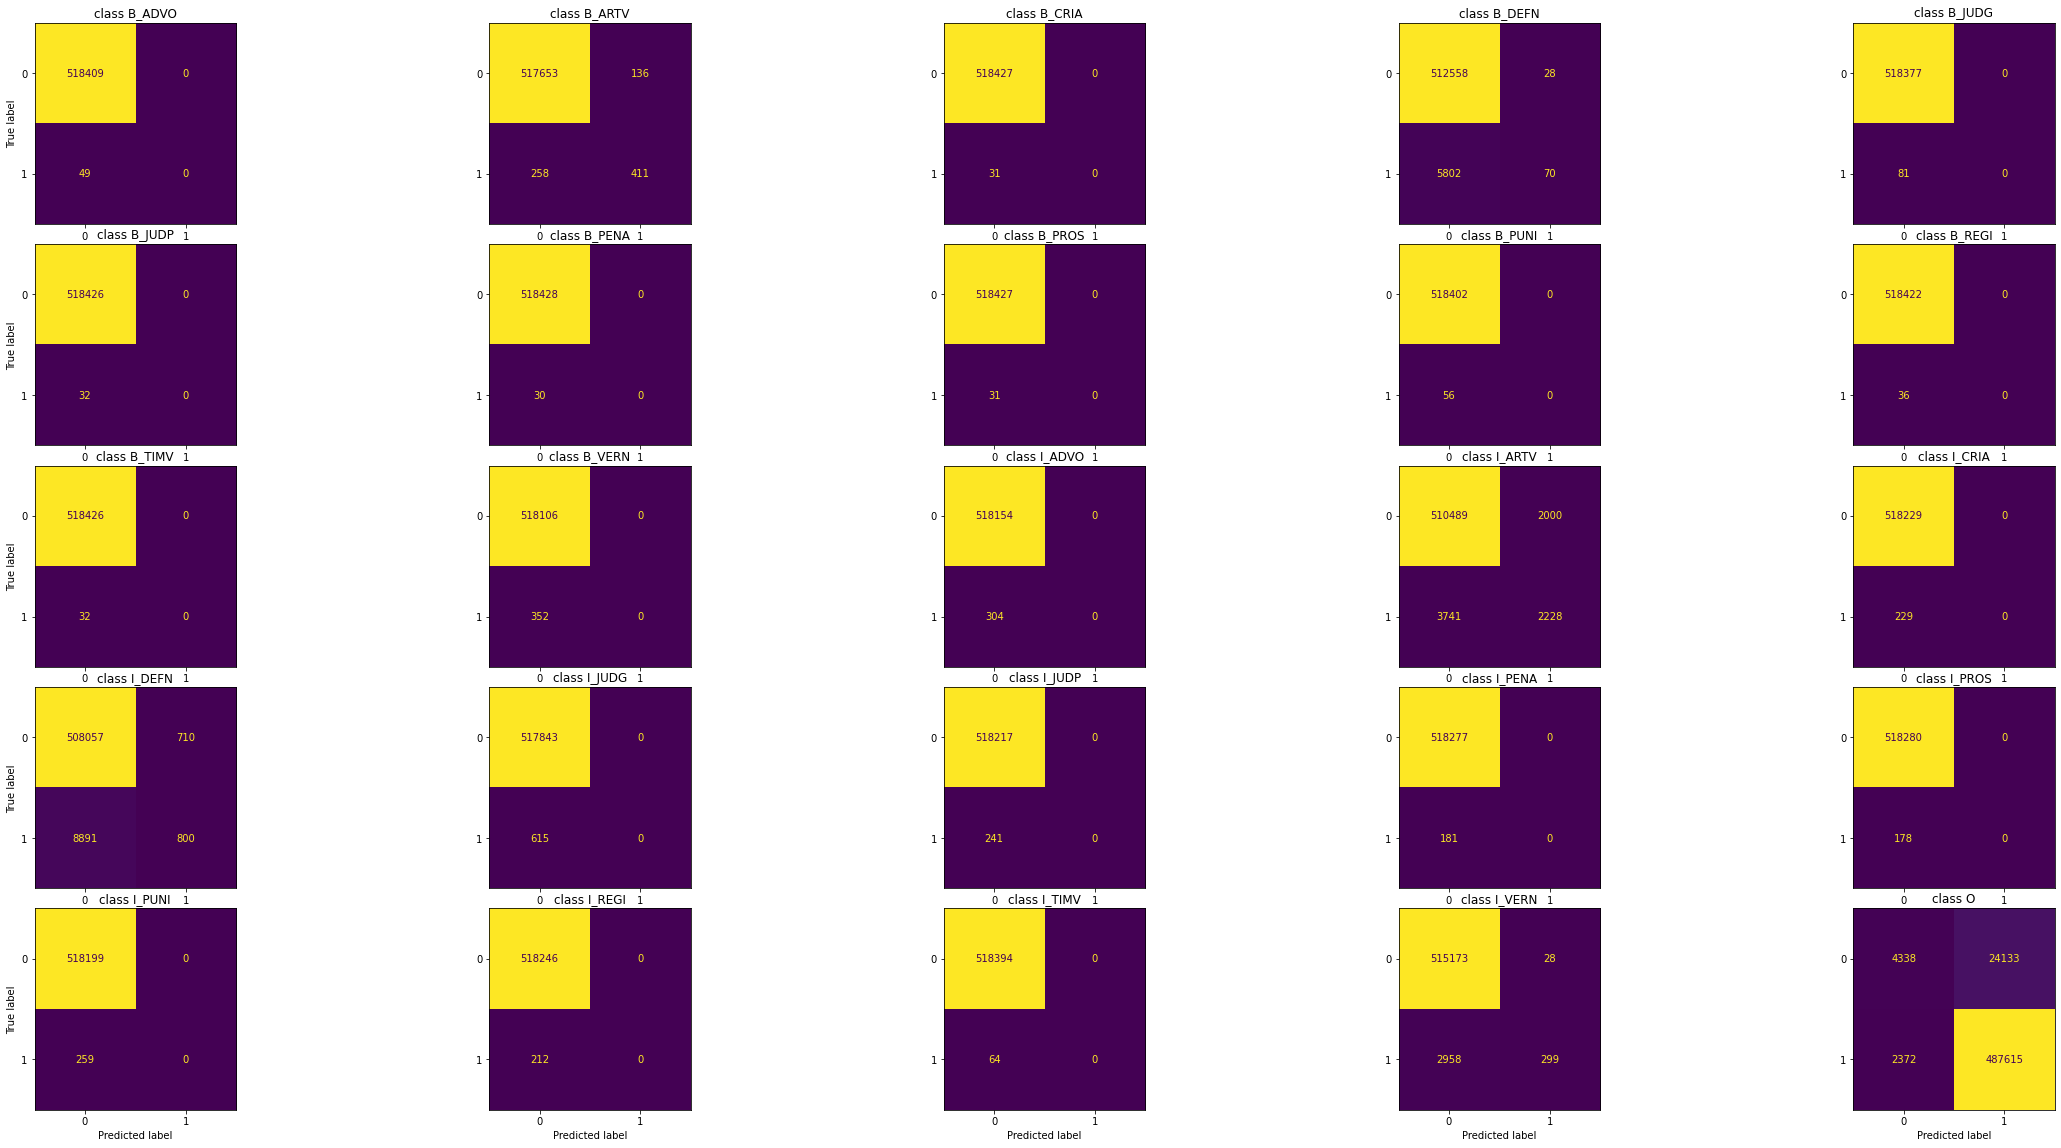

In [62]:
plot_cm(y_test, y_pred, classes)

## train model PassiveAggressiveClassifier

In [63]:
pac = PassiveAggressiveClassifier()
pac_start = time.time()
pac.partial_fit(X_train, y_train, classes)
pac_end = time.time()

### time model

In [64]:
print(f'{(pac_end - pac_start):.2f} Detik.')

1.99 Detik.


In [65]:
y_pred_pac = pac.predict(X_test)

### evaluasi

In [66]:
print(classification_report(y_pred=y_pred_pac, y_true=y_test, labels = classes))

              precision    recall  f1-score   support

      B_ADVO       0.00      0.00      0.00        49
      B_ARTV       0.51      0.91      0.65       669
      B_CRIA       0.00      0.00      0.00        31
      B_DEFN       0.40      0.17      0.24      5872
      B_JUDG       0.01      0.01      0.01        81
      B_JUDP       1.00      0.03      0.06        32
      B_PENA       0.00      0.00      0.00        30
      B_PROS       0.00      0.00      0.00        31
      B_PUNI       0.00      0.00      0.00        56
      B_REGI       0.00      0.00      0.00        36
      B_TIMV       0.00      0.00      0.00        32
      B_VERN       0.09      0.04      0.05       352
      I_ADVO       0.00      0.00      0.00       304
      I_ARTV       0.72      0.17      0.27      5969
      I_CRIA       0.00      0.00      0.00       229
      I_DEFN       0.43      0.13      0.20      9691
      I_JUDG       0.00      0.00      0.00       615
      I_JUDP       0.00    

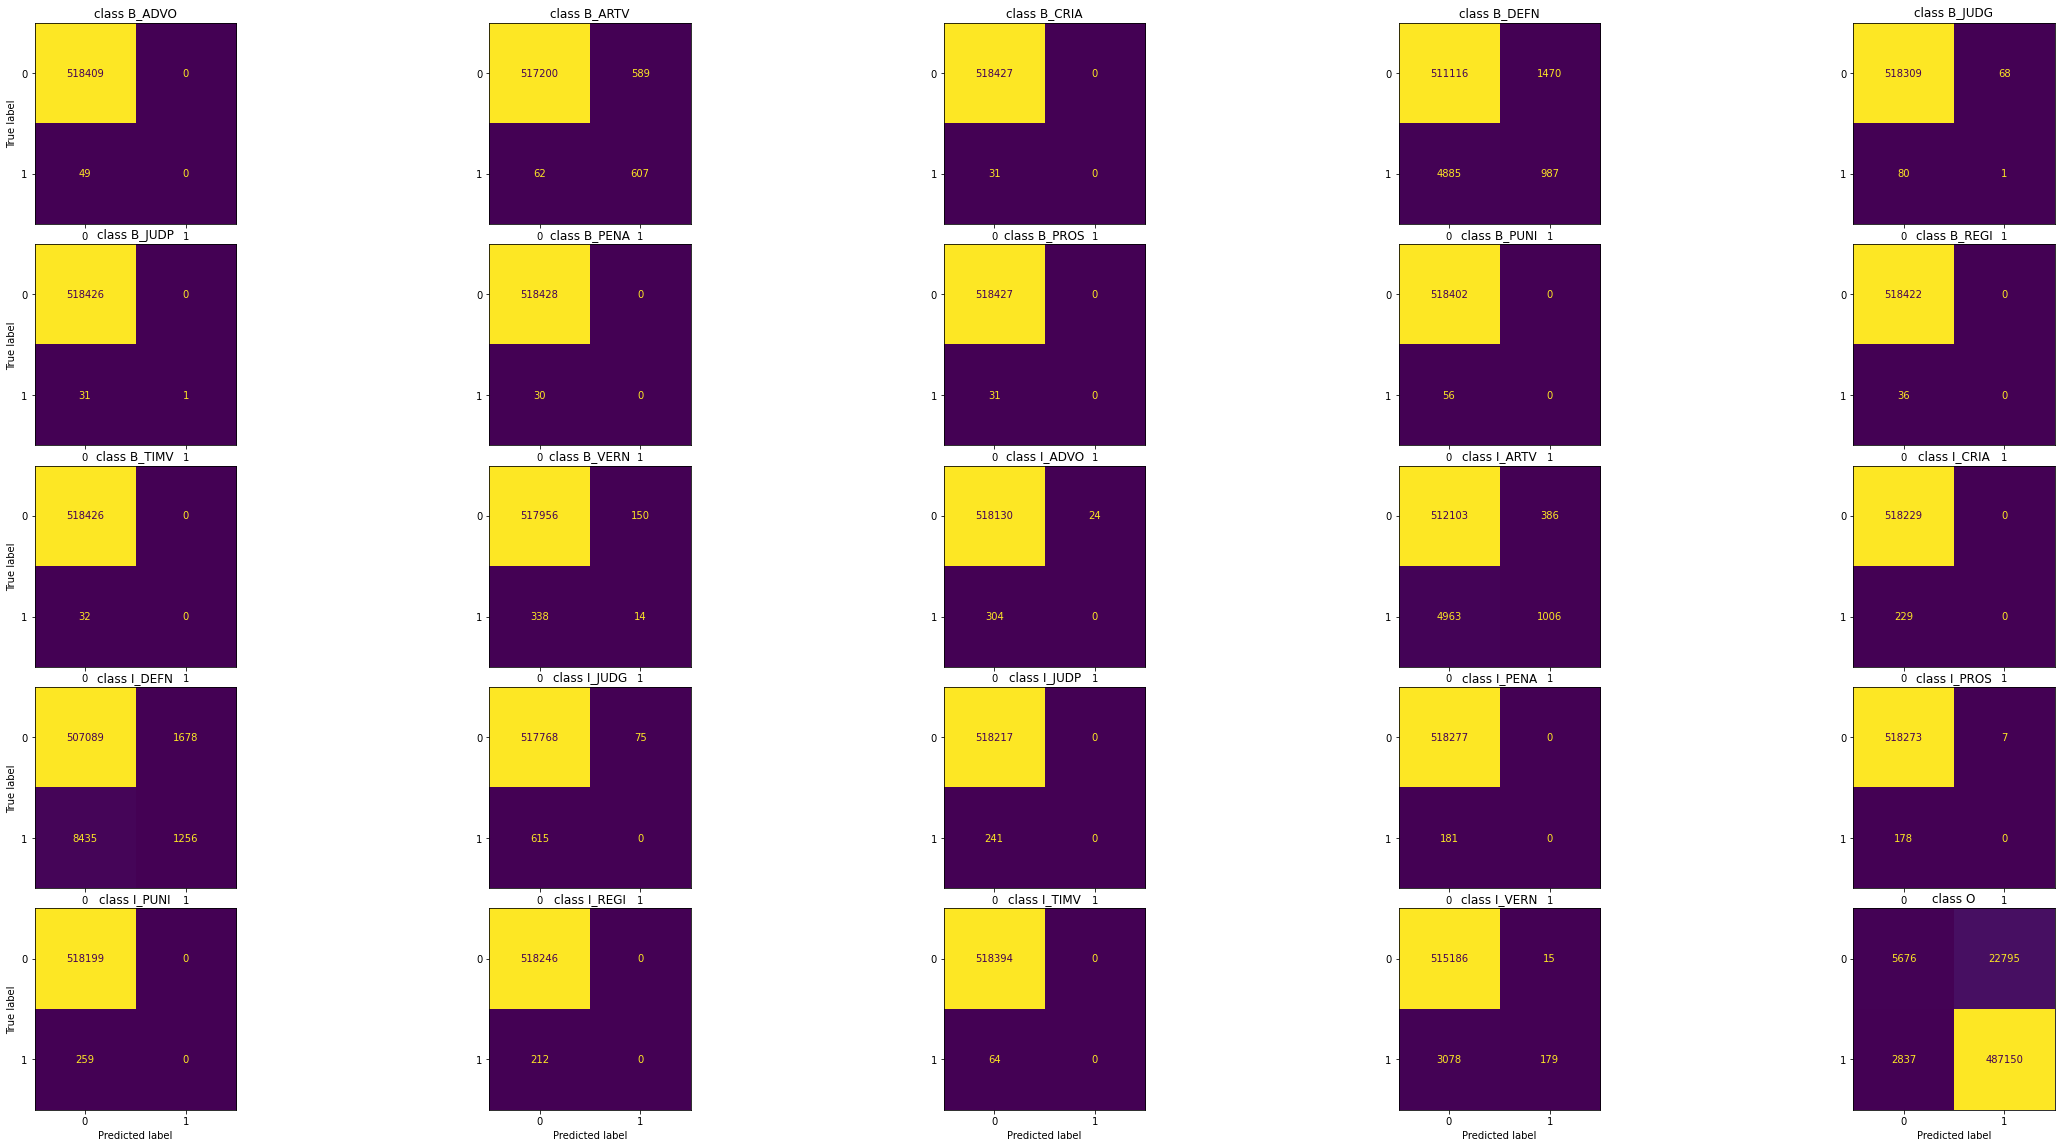

In [67]:
plot_cm(y_test, y_pred_pac, classes)

## train model perceptron

In [68]:
percept = Perceptron()
percept_start = time.time()
percept.partial_fit(X_train, y_train, classes)
percept_end = time.time()

### time model

In [69]:
print(f'{(percept_end - percept_start):.2f} Detik.')

1.92 Detik.


In [70]:
y_pred_percept = percept.predict(X_test)

### evaluasi

In [71]:
print(classification_report(y_pred=y_pred_percept, y_true=y_test, labels = classes))

              precision    recall  f1-score   support

      B_ADVO       0.00      0.00      0.00        49
      B_ARTV       0.74      0.41      0.52       669
      B_CRIA       0.00      0.00      0.00        31
      B_DEFN       0.38      0.17      0.24      5872
      B_JUDG       0.09      0.04      0.05        81
      B_JUDP       1.00      0.03      0.06        32
      B_PENA       0.00      0.00      0.00        30
      B_PROS       0.03      0.03      0.03        31
      B_PUNI       0.00      0.00      0.00        56
      B_REGI       0.01      0.08      0.01        36
      B_TIMV       0.00      0.00      0.00        32
      B_VERN       0.06      0.06      0.06       352
      I_ADVO       0.00      0.00      0.00       304
      I_ARTV       0.62      0.23      0.34      5969
      I_CRIA       0.00      0.00      0.00       229
      I_DEFN       0.44      0.12      0.19      9691
      I_JUDG       0.01      0.00      0.00       615
      I_JUDP       0.26    

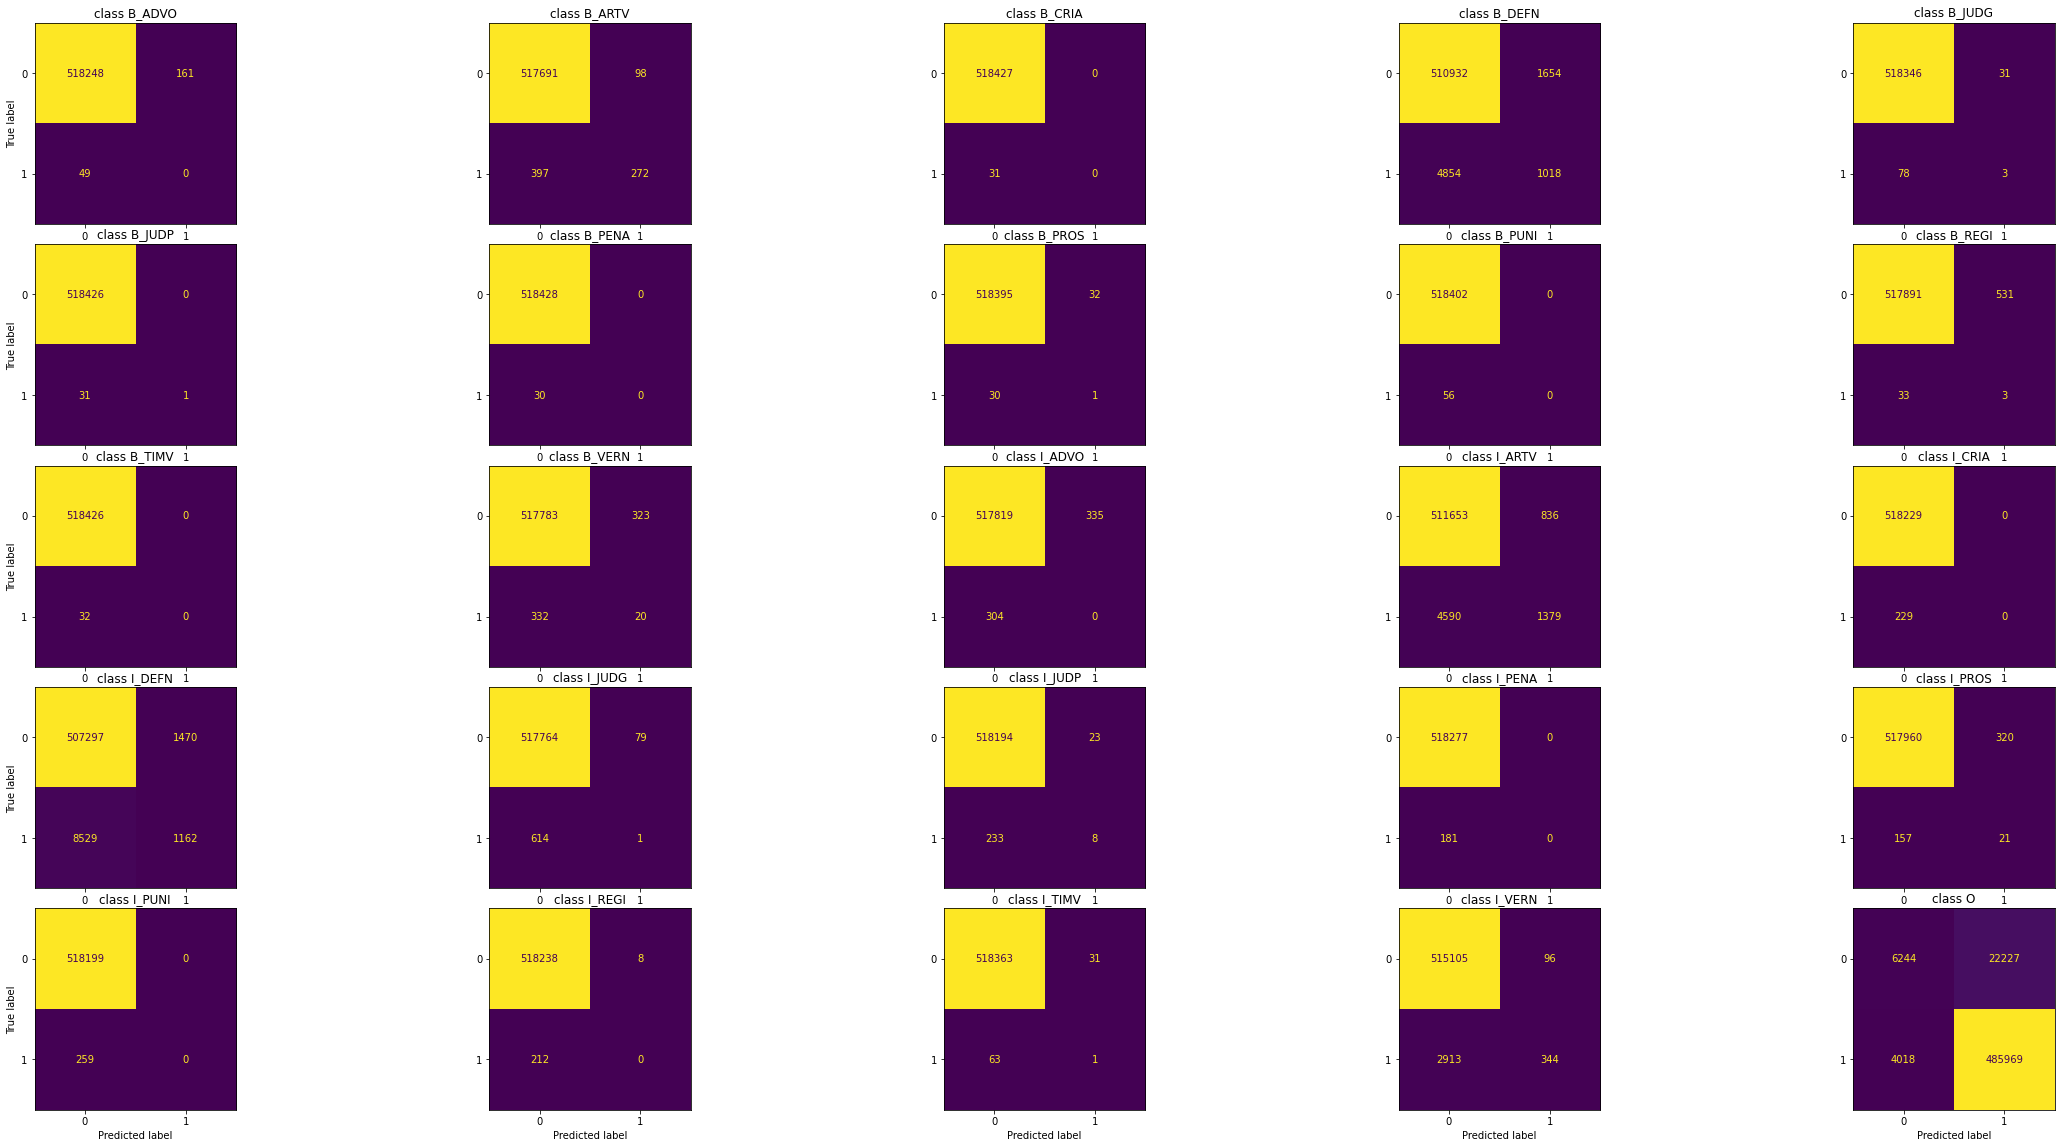

In [72]:
plot_cm(y_test, y_pred_percept, classes)

## train model svm

In [73]:
svm = SVC(kernel='linear', max_iter=100)
svm_start = time.time()
svm.fit(X_train, y_train)
svm_end = time.time()

### time model

In [74]:
print(f'{(svm_end - svm_start):.2f} Detik.')

47.53 Detik.


In [75]:
y_pred_svm = svm.predict(X_test)

### evaluasi

In [76]:
print(classification_report(y_pred=y_pred_svm, y_true=y_test, labels = classes))

              precision    recall  f1-score   support

      B_ADVO       0.02      0.02      0.02        49
      B_ARTV       0.39      0.98      0.56       669
      B_CRIA       0.01      0.39      0.01        31
      B_DEFN       0.33      0.12      0.17      5872
      B_JUDG       0.09      0.20      0.12        81
      B_JUDP       0.11      0.12      0.12        32
      B_PENA       0.00      0.30      0.01        30
      B_PROS       0.02      0.06      0.03        31
      B_PUNI       0.00      0.34      0.01        56
      B_REGI       0.03      0.14      0.05        36
      B_TIMV       0.00      0.28      0.01        32
      B_VERN       0.01      0.06      0.02       352
      I_ADVO       0.00      0.00      0.00       304
      I_ARTV       0.17      0.12      0.14      5969
      I_CRIA       0.00      0.23      0.01       229
      I_DEFN       0.20      0.02      0.04      9691
      I_JUDG       0.23      0.17      0.19       615
      I_JUDP       0.00    

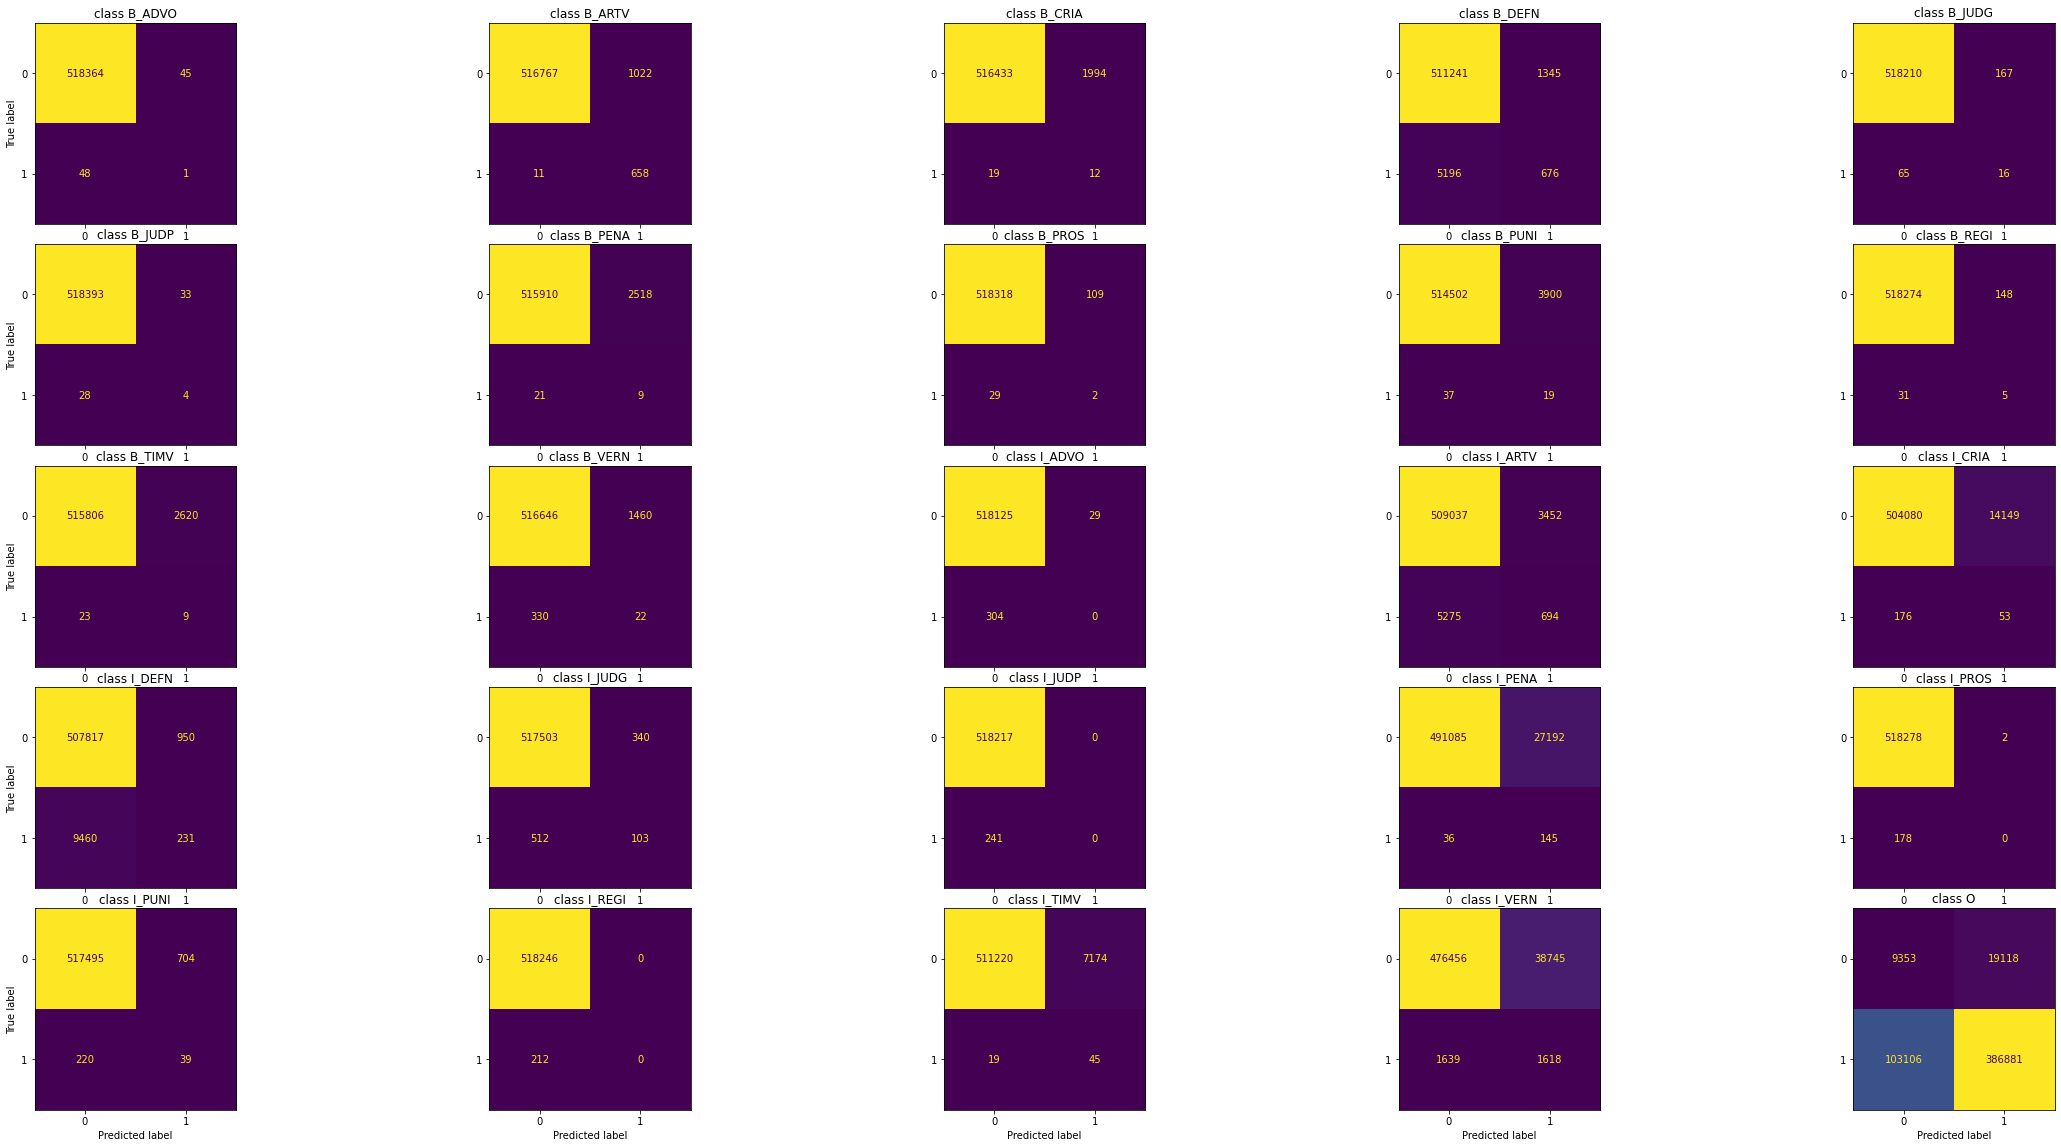

In [77]:
plot_cm(y_test, y_pred_svm, classes)

## train model crf

In [78]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), 
                                                          #  s['pos'].values.tolist(), 
                                                           s['tag'].values.tolist())]
        self.grouped = self.data.groupby('sentence').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None

In [79]:
X_crf = df.drop(['doc', 'pos', 'prev', 'next'], axis=1)
getter = SentenceGetter(X_crf)
sentences = getter.sentences

In [80]:
def word2features(sent, i):
    word = sent[i][0]
    # postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        # 'postag': postag,
        # 'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        # postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            # '-1:postag': postag1,
            # '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        # postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            # '+1:postag': postag1,
            # '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    
    return features

def sent2features(sent):
  return [word2features(sent, i) for i in range(len(sent))]
def sent2labels(sent):
  return [label for token, label in sent]
def sent2tokens(sent):
  return [token for token, label in sent]

In [81]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [82]:
new = X_crf[len_a+1:]
sentence_nuniq = new['sentence'].nunique()
sentence_nuniq

10747

In [83]:
X_train = X[:sentence_nuniq]
y_train = y[:sentence_nuniq]
X_test = X[sentence_nuniq:]
y_test = y[sentence_nuniq:]

In [84]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers

In [85]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf_start = time.time()
crf.fit(X_train, y_train)
crf_end = time.time()

### time model

In [86]:
print(f'{(crf_end - crf_start):.2f} Detik.')

157.02 Detik.


In [87]:
y_pred_crf= crf.predict(X_test)

### evaluasi

In [88]:
print(flat_classification_report(y_test, y_pred_crf, labels=classes))

              precision    recall  f1-score   support

      B_ADVO       0.75      0.05      0.10       279
      B_ARTV       0.94      0.87      0.91      1127
      B_CRIA       0.50      0.17      0.26        58
      B_DEFN       0.80      0.33      0.46      7702
      B_JUDG       0.89      0.54      0.67       179
      B_JUDP       0.78      0.55      0.64        66
      B_PENA       0.73      0.66      0.69        62
      B_PROS       0.82      0.54      0.65        59
      B_PUNI       0.81      0.77      0.79       103
      B_REGI       0.78      0.51      0.62        74
      B_TIMV       0.64      0.08      0.14        87
      B_VERN       0.76      0.46      0.57       315
      I_ADVO       0.82      0.15      0.25       741
      I_ARTV       0.92      0.95      0.93      9191
      I_CRIA       0.31      0.07      0.12       533
      I_DEFN       0.82      0.53      0.65     16045
      I_JUDG       0.87      0.66      0.75      1145
      I_JUDP       0.61    

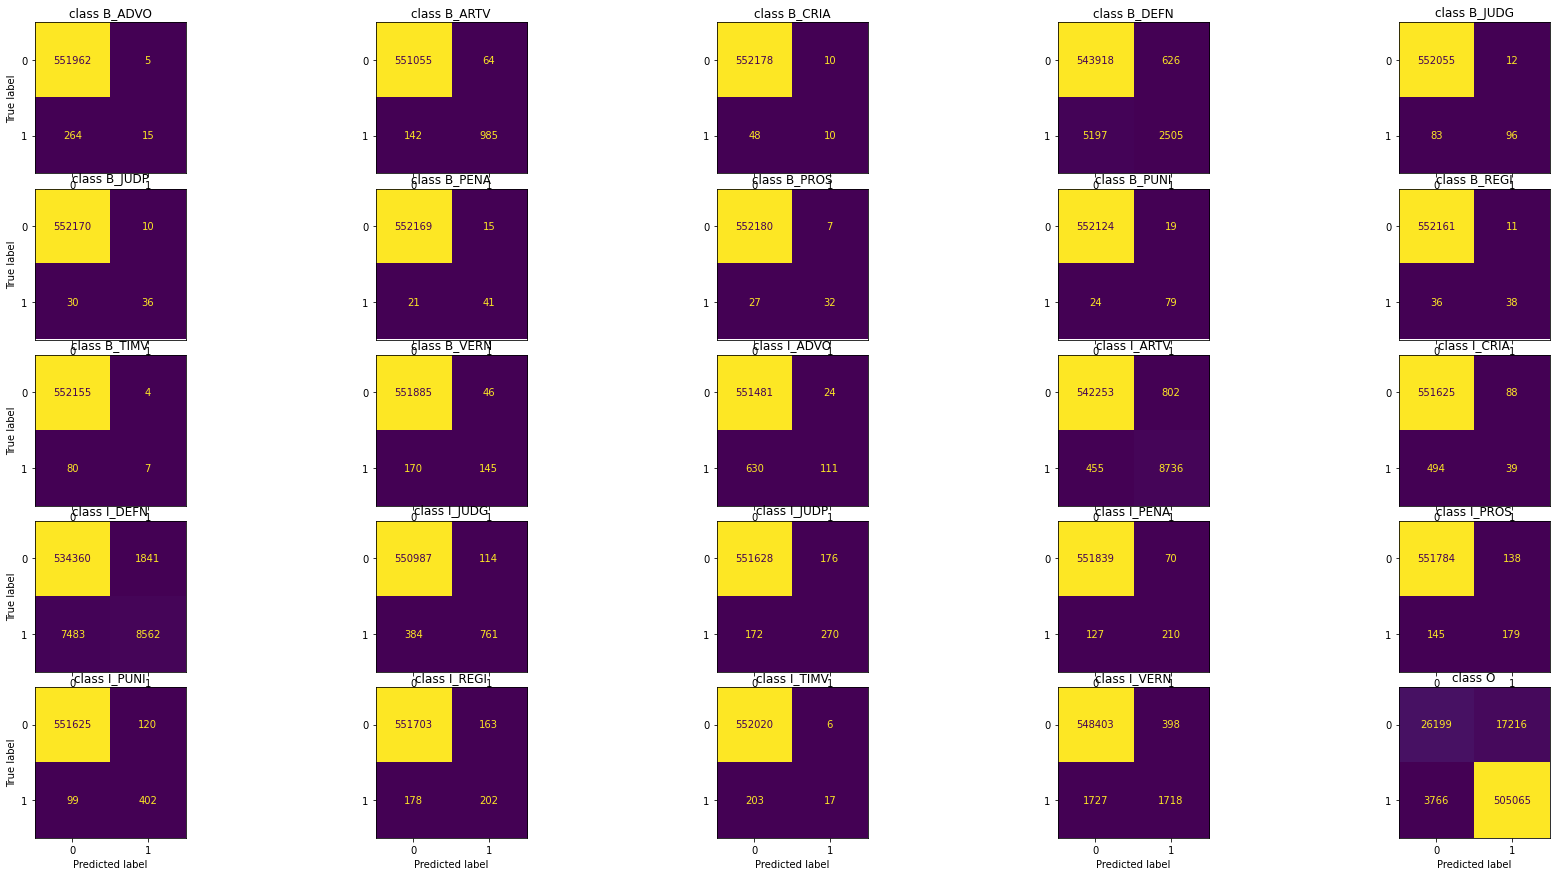

In [89]:
plot_cm_crf(y_test, y_pred_crf, classes)